<a href="https://colab.research.google.com/github/YaseenAli7812/Projects/blob/main/Object_Detection_with_YOLOv8_project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

awsaf49_coco_2017_dataset_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')
yaseenalikhan_iamges_path = kagglehub.dataset_download('yaseenalikhan/iamges')
yaseenalikhan_dog_and_cat_path = kagglehub.dataset_download('yaseenalikhan/dog-and-cat')
keras_yolov8_keras_yolo_v8_l_backbone_2_path = kagglehub.model_download('keras/yolov8/Keras/yolo_v8_l_backbone/2')

print('Data source import complete.')


In [ ]:
!pip install ultralytics torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 14.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
import os
from ultralytics import YOLO
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
os.listdir('/kaggle/input/')

['coco-2017-dataset', 'yolov8']

In [ ]:
import torch
import os
import shutil
import yaml
from IPython.display import Image, clear_output

In [ ]:
base_path = "/kaggle/input/coco-2017-dataset/coco2017"
print("Annotations:", os.listdir(os.path.join(base_path, "annotations")))
print("Training images:", len(os.listdir(os.path.join(base_path, "train2017"))))
print("Validation images:", len(os.listdir(os.path.join(base_path, "val2017"))))
print("Test images:", len(os.listdir(os.path.join(base_path, "test2017"))))

Annotations: ['person_keypoints_train2017.json', 'instances_val2017.json', 'instances_train2017.json', 'person_keypoints_val2017.json', 'captions_train2017.json', 'captions_val2017.json']
Training images: 118287
Validation images: 5000
Test images: 40670


In [ ]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
import json
from pycocotools.coco import COCO
import os

train_annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"
val_annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json"
train_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
val_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/val2017"
output_labels_train_dir = "/kaggle/working/dataset/labels/train"
output_labels_val_dir = "/kaggle/working/dataset/labels/val"

os.makedirs(output_labels_train_dir, exist_ok=True)
os.makedirs(output_labels_val_dir, exist_ok=True)

nc = 80
def convert_bbox_to_yolo(image_width, image_height, bbox):
    x, y, w, h = bbox
    x_center = (x + w / 2) / image_width
    y_center = (y + h / 2) / image_height
    w = w / image_width
    h = h / image_height
    return x_center, y_center, w, h

def process_coco_annotations(annotation_path, output_labels_dir, images_dir):

    coco = COCO(annotation_path)

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs([img_id])[0]
        img_filename = img_info['file_name']
        img_path = os.path.join(images_dir, img_filename)

        if not os.path.exists(img_path):
            print(f"Warning: {img_filename} not found in {images_dir}")
            continue

        img_width, img_height = img_info['width'], img_info['height']

        annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))

        label_file_path = os.path.join(output_labels_dir, f"{img_filename.split('.')[0]}.txt")
        with open(label_file_path, 'w') as label_file:
            seen_labels = set()
            for ann in annotations:
                if 'bbox' in ann:
                    bbox = convert_bbox_to_yolo(img_width, img_height, ann['bbox'])
                    class_id = ann['category_id'] - 1

                    if class_id >= nc:
                        # print(f"Warning: Class ID {class_id} in {img_filename} exceeds nc={nc}. Skipping this annotation.")
                        continue
                    label_str = f"{class_id} {' '.join(map(str, bbox))}\n"
                    if label_str not in seen_labels:
                        label_file.write(label_str)
                        seen_labels.add(label_str)
                    else:
                        print(f"Warning: Duplicate label found in {img_filename}. Skipping this annotation.")

# Process both training and validation annotations
process_coco_annotations(train_annotation_path, output_labels_train_dir, train_images_dir)
process_coco_annotations(val_annotation_path, output_labels_val_dir, val_images_dir)


loading annotations into memory...
Done (t=19.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


In [ ]:
import os

train_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
val_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/val2017"
output_train_images_dir = "/kaggle/working/dataset/images/train"
output_val_images_dir = "/kaggle/working/dataset/images/val"

os.makedirs(output_train_images_dir, exist_ok=True)
os.makedirs(output_val_images_dir, exist_ok=True)

for img_filename in os.listdir(train_images_dir):
    img_path = os.path.join(train_images_dir, img_filename)
    symlink_path = os.path.join(output_train_images_dir, img_filename)
    if not os.path.exists(symlink_path):
        os.symlink(img_path, symlink_path)

for img_filename in os.listdir(val_images_dir):
    img_path = os.path.join(val_images_dir, img_filename)
    symlink_path = os.path.join(output_val_images_dir, img_filename)
    if not os.path.exists(symlink_path):
        os.symlink(img_path, symlink_path)

In [ ]:
import json
from pycocotools.coco import COCO
annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"
coco = COCO(annotation_path)

categories = coco.loadCats(coco.getCatIds())
class_names = [category['name'] for category in categories]
print("Classes in COCO dataset:", class_names)

loading annotations into memory...
Done (t=16.99s)
creating index...
index created!
Classes in COCO dataset: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
data_yaml = """
train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/val
nc: 80  # Number of classes, which should be 80 for COCO dataset
names:
  0: 'person'
  1: 'bicycle'
  2: 'car'
  3: 'motorcycle'
  4: 'airplane'
  5: 'bus'
  6: 'train'
  7: 'truck'
  8: 'boat'
  9: 'traffic light'
  10: 'fire hydrant'
  11: 'N/A'
  12: 'stop sign'
  13: 'parking meter'
  14: 'bench'
  15: 'bird'
  16: 'cat'
  17: 'dog'
  18: 'horse'
  19: 'sheep'
  20: 'cow'
  21: 'elephant'
  22: 'bear'
  23: 'zebra'
  24: 'giraffe'
  25: 'N/A'
  26: 'backpack'
  27: 'umbrella'
  28: 'handbag'
  29: 'tie'
  30: 'suitcase'
  31: 'frisbee'
  32: 'skis'
  33: 'snowboard'
  34: 'sports ball'
  35: 'kite'
  36: 'baseball bat'
  37: 'baseball glove'
  38: 'skateboard'
  39: 'surfboard'
  40: 'tennis racket'
  41: 'bottle'
  42: 'wine glass'
  43: 'cup'
  44: 'fork'
  45: 'knife'
  46: 'spoon'
  47: 'bowl'
  48: 'banana'
  49: 'apple'
  50: 'sandwich'
  51: 'orange'
  52: 'broccoli'
  53: 'carrot'
  54: 'hot dog'
  55: 'pizza'
  56: 'donut'
  57: 'cake'
  58: 'chair'
  59: 'couch'
  60: 'potted plant'
  61: 'bed'
  62: 'dining table'
  63: 'toilet'
  64: 'tv'
  65: 'laptop'
  66: 'mouse'
  67: 'remote'
  68: 'keyboard'
  69: 'cell phone'
  70: 'microwave'
  71: 'oven'
  72: 'toaster'
  73: 'sink'
  74: 'refrigerator'
  75: 'book'
  76: 'clock'
  77: 'vase'
  78: 'scissors'
  79: 'teddy bear'
"""
with open('/kaggle/working/dataset/data.yaml', 'w') as f:
    f.write(data_yaml)


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')
model.train(data='/kaggle/working/dataset/data.yaml', epochs=5, batch=16, imgsz=640)

100%|██████████| 21.5M/21.5M [00:00<00:00, 24.2MB/s]


Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/dataset/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 4.16MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 118287 images, 4296 backgrounds, 0 corrupt: 100%|██████████| 118287/118287 [05:24<00:00, 364.96it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels/val... 5000 images, 198 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:14<00:00, 342.72it/s]


val: New cache created: /kaggle/working/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.74G      1.038      1.341       1.15        195        640: 100%|██████████| 7393/7393 [39:38<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:39<00:00,  3.99it/s]


                   all       5000      34430      0.655      0.532      0.571       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.7G      1.051      1.141      1.162        168        640: 100%|██████████| 7393/7393 [38:50<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


                   all       5000      34430      0.652      0.539      0.581      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.74G      1.055      1.149      1.167        288        640: 100%|██████████| 7393/7393 [38:21<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:36<00:00,  4.34it/s]


                   all       5000      34430      0.679      0.538      0.593      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.76G      1.042      1.117      1.159        146        640: 100%|██████████| 7393/7393 [38:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:36<00:00,  4.36it/s]


                   all       5000      34430      0.673      0.552      0.599      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.85G      1.023      1.067      1.147        121        640: 100%|██████████| 7393/7393 [38:03<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:35<00:00,  4.38it/s]


                   all       5000      34430      0.671      0.559      0.602      0.435

5 epochs completed in 3.275 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:39<00:00,  3.93it/s]


                   all       5000      34430      0.671      0.559      0.602      0.435
                person       2693      11004      0.799      0.695      0.783      0.557
               bicycle        149        316      0.681      0.443      0.545       0.32
                   car        535       1932      0.724      0.585      0.644      0.431
            motorcycle        159        371      0.788      0.623      0.716      0.466
              airplane         97        143      0.817      0.804      0.877      0.701
                   bus        189        285      0.803      0.719      0.804      0.679
                 train        157        190      0.811      0.816      0.863      0.666
                 truck        250        415      0.638      0.439      0.532       0.37
                  boat        121        430      0.657      0.402      0.485      0.265
         traffic light        191        637      0.681      0.419      0.489      0.262
          fire hydran

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c60c074a020>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,

In [ ]:
metrics = model.val(data='/kaggle/working/dataset/data.yaml')
print("Validation Results:")
print(metrics)

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/dataset/labels/val.cache... 5000 images, 198 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [00:44<00:00,  7.09it/s]


                   all       5000      34430       0.67      0.559      0.602      0.436
                person       2693      11004      0.799      0.696      0.783      0.558
               bicycle        149        316       0.68      0.443      0.539      0.319
                   car        535       1932      0.722      0.584      0.643       0.43
            motorcycle        159        371      0.791      0.623      0.714      0.466
              airplane         97        143      0.823      0.804      0.879      0.701
                   bus        189        285      0.806      0.719      0.805      0.677
                 train        157        190      0.809      0.816      0.863      0.667
                 truck        250        415      0.639      0.441      0.531       0.37
                  boat        121        430      0.653      0.402      0.478      0.264
         traffic light        191        637      0.682      0.421      0.492      0.264
          fire hydran

In [ ]:
test_images_path = '/kaggle/input/coco-2017-dataset/coco2017/test2017'
test_images = os.listdir(test_images_path)[:30]
test_images_full_paths = [os.path.join(test_images_path, img) for img in test_images]
results = model.predict(source=test_images_full_paths, save=True, save_txt=False)

from pathlib import Path

output_dir = Path("/kaggle/working/detect")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Results saved in: {output_dir}")



0: 640x640 1 bench, 4.8ms
1: 640x640 2 persons, 4 cars, 1 motorcycle, 1 traffic light, 4.8ms
2: 640x640 1 cup, 1 bowl, 1 chair, 1 mouse, 4.8ms
3: 640x640 2 persons, 4.8ms
4: 640x640 3 persons, 1 carrot, 1 cake, 4.8ms
5: 640x640 3 persons, 1 airplane, 4.8ms
6: 640x640 3 persons, 1 clock, 4.8ms
7: 640x640 5 zebras, 4.8ms
8: 640x640 3 cars, 1 motorcycle, 1 bed, 1 toilet, 4.8ms
9: 640x640 5 traffic lights, 4.8ms
10: 640x640 5 persons, 2 skateboards, 1 surfboard, 4.8ms
11: 640x640 2 persons, 1 sports ball, 4.8ms
12: 640x640 16 persons, 11 baseball gloves, 2 cups, 4.8ms
13: 640x640 2 persons, 3 sandwichs, 2 chairs, 1 bed, 1 mouse, 4.8ms
14: 640x640 4 persons, 1 bicycle, 2 cars, 2 stop signs, 4.8ms
15: 640x640 14 cups, 4.8ms
16: 640x640 2 scissorss, 4.8ms
17: 640x640 1 stop sign, 4.8ms
18: 640x640 1 person, 1 umbrella, 4.8ms
19: 640x640 1 car, 2 airplanes, 4.8ms
20: 640x640 1 clock, 4.8ms
21: 640x640 7 persons, 2 trains, 1 suitcase, 4.8ms
22: 640x640 3 beds, 3 toilets, 1 mouse, 1 oven, 4.8ms

In [ ]:
model.export(format='torchscript', save_dir='/kaggle/working/saved_models')

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (21.5 MB)

TorchScript: starting export with torch 2.4.0...
TorchScript: export success ✅ 3.8s, saved as 'runs/detect/train/weights/best.torchscript' (43.0 MB)

Export complete (5.8s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=/kaggle/working/dataset/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'

In [ ]:
from ultralytics import YOLO
from pathlib import Path

# Define the path to your single image
image_path = '/kaggle/input/dog-and-cat/images.jpg'  # Update this with your image path

# Load the YOLO model
model = YOLO('yolov8s.pt')  # Load the pre-trained YOLOv8 model (or your custom model)

# Perform prediction on the single image
results = model.predict(source=image_path, save=True, save_txt=False)

# Output results
output_dir = Path("/kaggle/working/detect")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Results saved")



image 1/1 /kaggle/input/dog-and-cat/images.jpg: 384x640 1 cat, 3 dogs, 111.7ms
Speed: 2.9ms preprocess, 111.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
Results saved


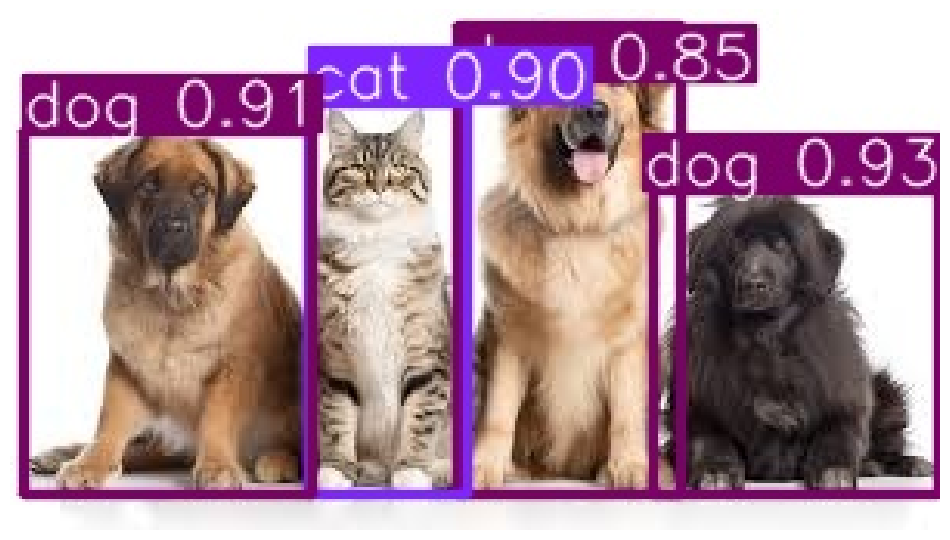

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the saved image
output_image_path = '/kaggle/working/runs/detect/predict2/images.jpg'

# Load and display the image in a larger size
img = mpimg.imread(output_image_path)
plt.figure(figsize=(12, 8))  # Adjust the figure size (width, height)
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.show()
